In [5]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
minpitch, maxpitch = 36, 92

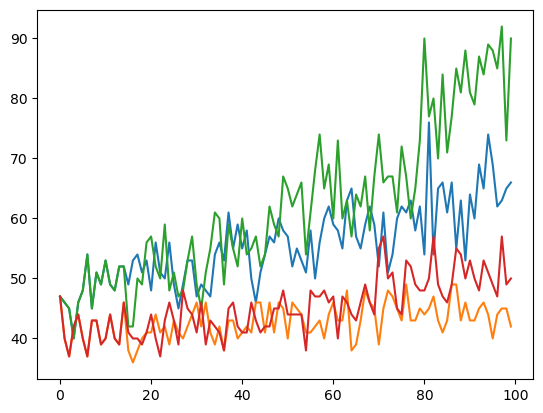

In [154]:
AR_hist = xr.open_mfdataset("*_AR_detection_p93_historical.nc")
AR_fut2 = xr.open_mfdataset("*_AR_detection_p93_ssp245.nc")
AR_fut5 = xr.open_mfdataset("*_AR_detection_p93_ssp585.nc")

def ext_pole(pole):
    if pole=='Antarctic':
        lmi,lma = -90,-60
    else:
        lmi,lma = 60,90

    AR_hist_yr_ARC = AR_hist.sel(lat=slice(lmi,lma))
    AR_hist_yr_ARC = AR_hist_yr_ARC.resample(time='1Y').sum()
    AR_hist_yr_ARC = AR_hist_yr_ARC.reduce(np.sum,dim=('lat','lon'))
    histar = AR_hist_yr_ARC.ivt.values

    arc245 = AR_fut2.sel(lat=slice(lmi,lma))
    arc245 = arc245.resample(time='1Y').sum()
    arc245 = arc245.reduce(np.sum,dim=('lat','lon')).ivt.values

    arc585 = AR_fut5.sel(lat=slice(lmi,lma))
    arc585 = arc585.resample(time='1Y').sum()
    arc585 = arc585.reduce(np.sum,dim=('lat','lon')).ivt.values

    arc245 = np.append(histar,arc245)
    arc585 = np.append(histar,arc585)

    return arc245,arc585
    
n245,n585 = ext_pole('Arctic')
s245,s585 = ext_pole('Antarctic')

mini = np.min([np.minimum(n245,n585),np.minimum(s245,s585)])
maxi = np.max([np.maximum(n245,n585),np.maximum(s245,s585)])

n245 = (n245-mini)/(maxi-mini)
n585 = (n585-mini)/(maxi-mini)
s245 = (s245-mini)/(maxi-mini)
s585 = (s585-mini)/(maxi-mini)

n245_ = minpitch+n245*(maxpitch-minpitch)
n585_ = minpitch+n585*(maxpitch-minpitch)
s245_ = minpitch+s245*(maxpitch-minpitch)
s585_ = minpitch+s585*(maxpitch-minpitch)

n245_ = n245_.astype(int)
n585_ = n585_.astype(int)
s245_ = s245_.astype(int)
s585_ = s585_.astype(int)

np.savetxt('585notes',n585_)

plt.plot(n245_)
plt.plot(s245_)
plt.plot(n585_)
plt.plot(s585_)
plt.show()

In [145]:
tst_ = pd.DataFrame({'val':n245_,'step':range(len(n245_))})
tst1_ = pd.DataFrame({'val':n585_,'step':range(len(n585_))})
tsts_ = pd.DataFrame({'val':s245_,'step':range(len(s245_))})
tsts1_ = pd.DataFrame({'val':s585_,'step':range(len(s585_))})

In [149]:
def _to_chords_(df, key):
    notes = range(len(np.arange(minpitch,maxpitch+1,1)))
    notes_ = np.arange(minpitch,maxpitch+1,1)
    maj = np.mod(notes,12)==key[0]
    tir = np.mod(notes,12)==key[1]
    qui = np.mod(notes,12)==key[2]
    sev = np.mod(notes,12)==key[3]
    auth = maj+tir+qui
    auth_notes = notes_[auth]
    notin = df.val.values
    i=0
    for nn in notin:
        dist = np.abs(auth_notes-nn)
        tru_note = auth_notes[np.argmin(dist)]
        notin[i] = tru_note
        i=i+1
    df['val'] = notin
    return df

In [147]:
def extract_sdt(indata,nm,kkeys):
    didif = [indata['step'].values[0]]
    indata = _to_chords_(indata,kkeys)
    for i in np.arange(1,len(tst_.val.values)):
        if indata['val'].values[i]==indata['val'].values[i-1]:
            didif = np.append(didif,indata['step'].values[i-1])
        else:
            didif = np.append(didif,indata['step'].values[i])
    indata['dif'] = didif
    steps = indata.groupby(['dif','val'],as_index=False).count().step.values
    vals = (indata.groupby(['dif','val'],as_index=False).mean().val.values).astype(int)
    new_df = pd.DataFrame({'note':vals,
                       'steps':np.cumsum(steps)-np.min(np.cumsum(steps)),
                       'duration':np.append(steps[1:],2),
                      'force':np.repeat(127,len(steps))})
    new_df = new_df[['steps','note','force','duration']]
    for j in np.arange(1,len(new_df.note.values)):
        if new_df.note.values[j] == new_df.note.values[j-1]:
            new_df.steps[j] = new_df.steps.values[j-1]
    dudu = new_df.groupby(['steps'],as_index=False).sum().duration.values
    new_df = new_df.drop_duplicates(['steps','note'])
    new_df.duration = dudu*12
    new_df.steps = new_df.steps*12
    new_df['force'] = np.linspace(100,126,len(dudu)).astype(int)
    new_df.to_csv(nm)
    return new_df

In [152]:
ar_ex = extract_sdt(tst_,'arcmus245',[0,4,7,10])
ar5_ex = extract_sdt(tst1_,'arcmus585',[0,4,7,10])
ant_ex = extract_sdt(tsts_,'antmus245',[0,4,7,10])
ant5_ex = extract_sdt(tsts1_,'antmus585',[0,4,7,10])